In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

<!-- requirement: images/matrix.svg -->
<!-- requirement: small_data/cal_house.json.gz -->
<!-- requirement: pylib/tf_utils.py -->
<!-- requirement: pylib/mnist_dataset.py -->
# Introduction to TensorFlow


As artificial intelligence has advanced, applications have needed to process larger and larger amounts of data.  A prime example of this is the field of neural networks.  These machine learning models are enormously flexible and powerful, but they require huge amounts of both time and data to train.  Building tools to accomplish this can be difficult.

Google had been using neural networks internally for some time when they decided to develop a single framework flexible enough to be used for many different purposes.  That project became TensorFlow, and it was released as an open-source project in November, 2015.  Version 1.0 was released just over a year later, in February, 2017. Version 2.0 (used by this course) was released in 2019.

This generality has made TensorFlow useful for a number of different applications.  At its heart, it is a general-purpose computation engine, optimized for large data.  With TensorFlow, you define your program in terms of a computation graph.  Then, the graph is executed by letting data, in the form of tensors, flow through it.  (And you thought the name was just chosen to sound good!)

This course will introduce you to both the basics of TensorFlow and the basics of neural networks.  By focusing on the basics, we hope to convey a solid understanding of the theory of deep learning and practice implementing neural networks in TensorFlow.  For purposes of time, many of our example will be small and short, and therefore will not produce spectacular results.  Nonetheless, this should be enough to get you started on your own spectacular projects!


### Topics Covered


- Machine Learning


- Computation Graph


- Basic Neural Networks


- Deep Neural Networks


- Convolutional Neural Networks


- Recurrent Neural Networks


- Adversarial Noise


- Variational Autoencoders


- DeepDream

# Machine Learning in TensorFlow


**Machine Learning** is a broad collection of tools used to find patterns in existing data and to make predictions about future data. **Deep learning** refers to machine learning with powerful neural networks, a flexible architecture that has made it possible for computers to complete tasks that previously were very difficult. For example, we can use deep learning algorithms to [generate captions](https://research.googleblog.com/2016/09/show-and-tell-image-captioning-open.html), [summarize](https://research.googleblog.com/2016/08/text-summarization-with-tensorflow.html) and [translate](https://research.googleblog.com/2016/09/a-neural-network-for-machine.html) text, [generate audio](https://deepmind.com/blog/wavenet-generative-model-raw-audio/), and [produce art](https://github.com/lengstrom/fast-style-transfer/). We will learn how neural networks work and the principles of deep learning, implementing models in TensorFlow. We'll begin with a review of machine learning.

Almost all of the examples we will discuss in this course will be examples of **supervised machine learning**.  In supervised machine learning, we deal with two data structures, a **feature matrix** $X_{ji}$ and a **label vector** $y_j$.  Each column $i$ of the feature matrix represents one particular **feature**.  (Each feature must be a numeric value.  The process of converting non-numeric data into numeric data is called **vectorization**, but we will not cover it in detail.)  Each row $j$ of the feature matrix represents a particular **observation**.  Each observation has a single value for each feature, recorded as $X_{ji}$.  Each observation also has an associated label $y_j$.

![feature matrix](images/matrix.svg)

The goal of supervised machine learning is to build a function $f$ that can estimate the value of the label from the associated row of the feature matrix.  That is, we wish to have

$$ f(X_{j\cdot}) \approx y_j $$

Once we have such a function, we can predict the label for a new observation $\tilde x$ with $f(\tilde x)$.

Supervised machine learning is further divided by the type of label.  **Regression** is the case when the label is quantitative.  In this case, the distance between the actual and predicted label is meaningful.  Prediction of a house price is an example of regression.  If the label just indicates a class (i.e. is categorical), the problem is **classification**.  There is no inherent ordering of the classes; the difference of the actual and predicted labels is not meaningful, except in the sense of whether it is non-zero.  Predicting whether a home will sell or not would be a classification problem.


## Linear models


A particular regression algorithm is defined by two things: the functional form of $f$ and the error metric being minimized.  We'll start by discussing the former.

A linear model is one that is linear in each of the features.  That is, we can write

$$ f(X_{j\cdot}) = \sum_i X_{ji} W_i + b $$

where $W_i$ is a vector of weights, one for each feature, and $b$ is a bias term.  In the fitting process, we choose values for these parameters to optimize the model.

For concrete example, we'll load in some census data about housing prices in California.

In [3]:
import gzip
import json
from sklearn.model_selection import ShuffleSplit

with gzip.open("small_data/cal_house.json.gz", "r") as fin:
    housing = json.load(fin)

For reasons we will discuss later, it's a good idea to separate the data into a training set and a testing set.  This code puts 80% of the data in the training set and reserves 20% for testing.

In [4]:
for train, test in ShuffleSplit(1, 0.2, random_state=42).split(housing['data']):
    X_train = np.array(housing['data'])[train].astype(np.float32)
    y_train = np.array(housing['target'])[train].astype(np.float32)
    X_test = np.array(housing['data'])[test].astype(np.float32)
    y_test = np.array(housing['target'])[test].astype(np.float32)

print(X_train.shape, X_test.shape)

(16512, 8) (4128, 8)


We have 8 different features.  (We're not going to worry about what they represent right now.)  The training data are over 16K different observations.  This is actually a small number, compared to what we'll see later, but it suits us for right now.

We're also going to shift and scale the features, so that all columns are centered about zero and have a standard deviation of 1.  The reasoning for this will be discussed later.

In [5]:
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

Xs_train = (X_train - X_mean) / X_std
Xs_test = (X_test - X_mean) / X_std

print("Mean:", Xs_test.mean())
print("Std: ", Xs_test.std())

Mean: -0.004759329
Std:  1.017745


Let's start by considering just a single feature.  In this case, there is a single weight, and the model is simply

$$ f(X_j) = X_j W + b $$

Take a minute to adjust the weight and bias parameters below to generate a fit that looks good.

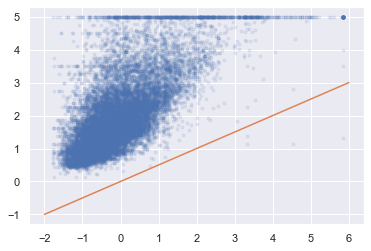

In [6]:
W = 0.5  # Weight
b = 0    # Bias

plt.plot(Xs_train[:,0], y_train, '.', alpha=0.1)
xx = np.linspace(-2, 6)
plt.plot(xx, xx * W + b)

## Error metrics


We can actually do quite well fitting a line by eye, at least in the case of a single feature.  But we would rather let the computer do the fitting for us, and to do this, we need a measure of how good a fit is.  This is the task of an **error metric**.

There are a number of different metrics for regression, but we will consider only the **mean squared error** (MSE).  For each observation $j$, the error is just the difference between the actual, or **ground truth**, label and the prediction: $f(X_{j\cdot}) - y_j$.  We generally don't care about the sign of the error (being high or low is equally bad), so we'll take the square of this value and average that over all the observations.

$$ MSE = \frac1n \sum_{j=1}^{n} \left[ f(X_{j\cdot}) - y_j \right]^2 $$

If we add this calculation, we no longer have to rely on our eyes to tell us the quality of the fit.

Training Error: 0.75619984
Testing Error:  0.76458055


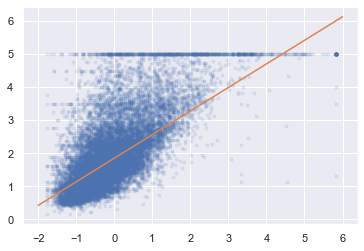

In [7]:
W = 0.71278  # Weight
b = 1.849    # Bias

plt.plot(Xs_train[:,0], y_train, '.', alpha=0.1)
plt.plot(xx, xx * W + b)

print("Training Error:", ((Xs_train[:,0] * W + b - y_train)**2).mean())
print("Testing Error: ", ((Xs_test[:,0] * W + b - y_test)**2).mean())

Note that we look at both the error on the training data and the testing data.  Since the goal of our model is to make accurate predictions about new data, not used in training, the testing error is a more honest representation of the performance of our model.

In this case, you'll find that the training and testing error are nearly the same.  As our models become more complicated, we'll see that there's a danger in **overfitting**: The model becomes so flexible that it can fit non-generic noise in the training set.  This shows up as an increasing gap between the training and testing errors. We'll discuss strategies to deal with overfitting later.


## Gradient descent


Now that we have a model and metric to measure it's performance, we need an algorithm to choose the best parameters for that model.  This is another place where there are several choices; we'll discuss the **gradient descent** algorithm.

As an introductory example, let's consider the case where we are optimizing just a single weight parameter $W$.  Then we can write the total error, or **loss** as a function of that: $L(W)$.  We want to find $W^*$ such that $L(W^*)$ is a minimum, or equivalently, so $dL(W^*)/dW = 0$.  We could use [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) on the derivative (or *gradient*) of the loss function to find its minimum:

$$ W^* = W - \left. \frac{dL}{dW} \middle/ \frac{d^2 L}{dW^2} \right. $$

For gradient descent, we'll assume that we can calculate (or at least approximate) the first derivative, but not the second derivative.  (In the multi-dimensional case, the first derivative becomes the gradient vector and the second derivative becomes the **Hessian** matrix, which requires a bit more work to compute.)  Instead, we make use only of the knowledge that near a minimum the second derivative will be positive.  Thus, in gradient descent, the parameters are updated according to

$$ W^* = W - \eta \frac{dL}{dW} $$

where $\eta$ is a constant called the **learning rate**.

The learning rate is an example of a **hyperparameter**.  This is a number that enters the model, but is not set during the fitting process.  You will need to choose hyperparameters before running the model, and you may need to spend some adjusting them to get the model behaving properly.  (That said, for linear regression, we can estimate the Hessian of the loss to be the covariance of the feature columns.  This is why we normalized them at the beginning.)

> **Aside:** Gradient descent is not the only way to fit a linear model.  Linear regression actually admits an exact solution to the model $f(X_{j\cdot}) = X_{j\cdot} \cdot W$, namely

> $$ \hat W = \left( X^T X \right)^{-1} X^T y $$

> For this particular example, linear regression would work just fine.  However, these matrix operations become increasing expensive and numerically unstable as the size of the feature matrix grows.  When there are many observations and/or features, gradient descent will generally be faster.

Let's set up the one-feature linear model that learns by gradient descent. Since we don't know any good initial parameters for fitting our data, we'll initialize the weight and bias to be zero. In this case, we can compute the gradients of the loss function with respect to the model parameters by hand.

$$ L(W, b) = \frac1n \sum_{j=1}^{n} \left[ X_j W + b - y_j \right]^2 $$

$$ \frac{\partial L}{\partial W} = \frac1n \sum_{j=1}^{n} 2X_j\left[ X_j W + b - y_j \right]$$

$$ \frac{\partial L}{\partial b} = \frac1n \sum_{j=1}^{n} 2\left[ X_j W + b - y_j \right]$$

We'll write a `LinearRegression` class that calculates these gradients and uses them to iteratively adjust the model parameters.

In [8]:
class LinearRegression():
    def __init__(self, eta=.1):
        self.W = 0
        self.b = 0
        self.eta = eta
    
    def loss(self, X, y):
        return ((X * self.W + self.b - y) ** 2).mean()
    
    def _gradients(self, X, y):
        return {'W': (2 * X * (X * self.W + self.b - y)).mean(),
                'b': (2 * (X * self.W + self.b - y)).mean()}
        
    def fit(self, X, y, steps=10):
        for _ in range(steps):
            gradients = self._gradients(X, y)
            self.W = self.W - self.eta * gradients['W']
            self.b = self.b - self.eta * gradients['b']
            
        return self

In [9]:
model = LinearRegression()

print('W: {}'.format(model.W))
print('b: {}'.format(model.b))
print('MSE: {}'.format(model.loss(Xs_test[:, 0:1], y_test.reshape(-1, 1))))

print()
print('Fitting the model...')
model.fit(Xs_train[:, 0:1], y_train.reshape(-1, 1), steps=20)

print('W: {}'.format(model.W))
print('b: {}'.format(model.b))
print('MSE: {}'.format(model.loss(Xs_test[:, 0:1], y_test.reshape(-1, 1))))

W: 0
b: 0
MSE: 5.533446311950684

Fitting the model...
W: 0.7893144240602853
b: 2.0480552770197398
MSE: 0.709713339805603


## Gradient Descent in TensorFlow

For even marginally more complex loss functions or models, analytical calculation of gradients becomes impractical or impossible. Numerical methods/finite differences on the other hand suffer from numerical instabilities and errors. [**Automatic differentiation**](https://en.wikipedia.org/wiki/Automatic_differentiation) is a method for computing derivatives efficiently and precisely by applying [chain rule](https://en.wikipedia.org/wiki/Chain_rule) to compositions of elementary mathematical operations (which describes many machine learning models). TensorFlow implements automatic differentiation by maintaining a record of these elementary mathematical operations, from which it compute the gradient of any tensor with respect to any other tensor in the graph.

In [10]:
class AutoLinearRegression():
    def __init__(self, eta=.1):
        self.W = tf.Variable(0.)
        self.b = tf.Variable(0.)
        self.eta = eta
    
    def loss(self, X, y):
        return tf.reduce_mean(tf.square(X * self.W + self.b - y))
    
    def _gradients(self, X, y):
        with tf.GradientTape() as tape:
            loss = self.loss(X, y)
        
        return tape.gradient(loss, [self.W, self.b])
    
    def fit(self, X, y, steps=10):
        for _ in range(steps):
            gradients = self._gradients(X, y)
            self.W.assign(self.W - self.eta * gradients[0])
            self.b.assign(self.b - self.eta * gradients[1])
            
        return self

In [11]:
model = AutoLinearRegression()

print('W: {}'.format(model.W))
print('b: {}'.format(model.b))
print('MSE: {}'.format(model.loss(Xs_test[:, 0:1], y_test.reshape(-1, 1))))

print()
print('Fitting the model...')
model.fit(Xs_train[:, 0:1], y_train.reshape(-1, 1), steps=20)

print('W: {}'.format(model.W))
print('b: {}'.format(model.b))
print('MSE: {}'.format(model.loss(Xs_test[:, 0:1], y_test.reshape(-1, 1))))

W: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
b: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
MSE: 5.533446311950684

Fitting the model...
W: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.7893144>
b: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0480554>
MSE: 0.709713339805603


Comparing `AutoLinearRegression` to `LinearRegression`, we can see three main differences:

1. Computation of the `loss` uses TensorFlow operations instead of NumPy.
2. The model parameters, `W` and `b` are now `tf.Variable` objects rather than Python built-ins.
3. The gradients are computed within the `tf.GradientTape` context handler.

## Tensors and Operations

TensorFlow tensors are similar to NumPy arrays, but carry additional optimizations for specific mathematical operations. Inspecting a `Tensor` object, we can see that similar to a NumPy array it has a `shape` and `dtype`, and that it additionally has a `numpy` equivalent.

In [12]:
x = tf.constant(2)
x

<tf.Tensor: id=904, shape=(), dtype=int32, numpy=2>

In [13]:
y = tf.constant(3)
z = x + y
z

<tf.Tensor: id=906, shape=(), dtype=int32, numpy=5>

In [14]:
z.numpy()

5

In fact, arrays will be converted into tensors when used with TensorFlow operations and tensors will be converted into arrays when used with NumPy operations.

In [15]:
tf.add(np.array([1, 2]), np.array([3, 4]))

<tf.Tensor: id=909, shape=(2,), dtype=int64, numpy=array([4, 6])>

In [16]:
np.add(tf.constant([1, 2]), tf.constant([3, 4]))

array([4, 6], dtype=int32)

Unlike NumPy arrays, TensorFlow requires strict agreement between the `dtype` of tensors that are used in the same calculation.

In [17]:
tf.constant(2, dtype=tf.int32) + tf.constant(2., dtype=tf.float32)

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:AddV2] name: add/

Also unlike NumPy arrays, (most) tensors are immutable. The exception is `tf.Variable` tensors. This distinction helps TensorFlow efficiently calculate gradients.

In [18]:
mat = tf.constant([[1, 2], [3, 4]])
mat[1, 1] = 5

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [19]:
var = tf.Variable([[1, 2], [3, 4]])
print(var)

var[1, 1].assign(5)
print(var)

<tf.Variable 'Variable:0' shape=(2, 2) dtype=int32, numpy=
array([[1, 2],
       [3, 4]], dtype=int32)>
<tf.Variable 'Variable:0' shape=(2, 2) dtype=int32, numpy=
array([[1, 2],
       [3, 5]], dtype=int32)>


You may notice that we use `tf.Variable.assign` to mutate the values instead of the typical `var[1, 1] = 5` (which uses the `__setitem__` dunder method in Python). This is because variable assignment is a TensorFlow operation that may be used in automatic differentiation.

As we've seen above, TensorFlow overloads arithmetic operators (addition, multiplication, etc.) so we may use `+` instead of `tf.add`, but TensorFlow supplies many other mathematical operations in the [`tf.math` module](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/math) (and many of those functions are aliased at the `tf` level, such as `tf.reduce_mean`).

### Exercise: Computation with tensors

Compute the sum of the squares of the average value of each row of the tensor provided below.

In [20]:
# Answer: 25.2332
tf.random.set_seed(42)
random_tensor = tf.random.uniform(shape=(100, 10))

In [21]:
tf.reduce_sum(tf.reduce_mean(random_tensor, axis=1) ** 2)

<tf.Tensor: id=942, shape=(), dtype=float32, numpy=25.2332>

## Automatic Differentiation and `tf.GradientTape`

Any TensorFlow operations computed within a `tf.GradientTape` context handler are recorded for automatic differentiation. Note that by default, TensorFlow will only track operations on `tf.Variable` (as in calculus, we only compute derivatives with respect to variables, not constants).

In [22]:
x = tf.Variable(2.)
with tf.GradientTape() as tape:
    y = x**2
    
tape.gradient(y, x)

<tf.Tensor: id=958, shape=(), dtype=float32, numpy=4.0>

In [23]:
x = tf.constant(2.)
with tf.GradientTape() as tape:
    y = x**2
    
tape.gradient(y, x) # this returns None

Note that TensorFlow only tracks operations that are computed within the `tf.GradientTape` context handler.

In [24]:
x = tf.Variable(2.)
xx = x**2
with tf.GradientTape() as tape:
    y = xx + 1
    
tape.gradient(y, x)

In [25]:
x = tf.Variable(2.)
with tf.GradientTape() as tape:
    xx = x**2
    y = xx + 1
    
tape.gradient(y, x)

<tf.Tensor: id=991, shape=(), dtype=float32, numpy=4.0>

[We can manipulate more details of `tf.GradientTape`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape) but this basic approach is all we need to get started with gradient descent.

### Exercise: Minimizing arbitrary functions

Using TensorFlow's automatic differentiation, we can find minima/maxima of arbitrary functions. The [gamma function](https://en.wikipedia.org/wiki/Gamma_function) is an extension of the factorial.  It is defined as

$$ \Gamma(x) = \int_0^\infty y^{x-1} e^{-y} dy $$

For integers, $\Gamma(n) = (n-1)!$.  TensorFlow doesn't provide the gamma function directly, but it does have the `lgamma()` function, which gives the logarithm of the gamma function.  (Actually, it's the log of the absolute value, but $\Gamma(x) > 0 \ \forall x > 0$, which is good enough for us.)  We also have the exponential function, so we can recreate it easily:

Text(0, 0.5, '$\\Gamma(x)$')

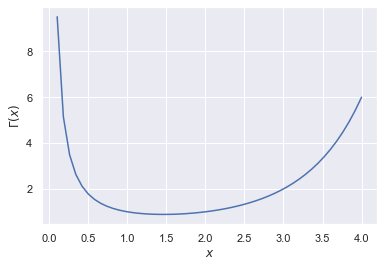

In [26]:
xx = np.linspace(0.1,4)
plt.plot(xx, tf.exp(tf.math.lgamma(xx)).numpy())
plt.xlabel('$x$')
plt.ylabel(r'$\Gamma(x)$')

As you can see, it has a minimum around 1.5.  Write a algorithm to find the position of the minimum.

In [27]:
x = tf.Variable(1.)
eta = 1
n_steps = 10

for _ in range(n_steps):
    with tf.GradientTape() as tape:
        f = tf.exp(tf.math.lgamma(x))
        
        gradient = tape.gradient(f, x)
        x.assign(x - eta * gradient)

x

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.4616323>

## Built-in optimization


TensorFlow has a number of optimizers, including a gradient descent optimizer, built in.  Instead of applying the gradient descent step ourselves, we can pass an optimizer's `apply_gradients` method a list of gradient-variable pairs, and the variables will be updated.  Alternatively, we can call the optimizer's `minimize` method and pass a loss function directly and avoid computing the gradients ourselves.

This is particularly useful since some optimizers offer additional features such as adaptive learning rates, momentum, etc.

**Note:** [The `minimize` method of Keras optimizers](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers/SGD#minimize) requires the `loss` argument to be a function with no arguments; we have re-written the `AutoLinearRegression` to meet this requirement.

In [28]:
class AutoLinearRegression():
    def __init__(self, eta=.1):
        self.W = tf.Variable(0.)
        self.b = tf.Variable(0.)
        self.opt = tf.keras.optimizers.SGD(learning_rate=eta)
    
    def loss(self, X, y, return_func=False):
        def loss_():
            return tf.reduce_mean(tf.square(X * self.W + self.b - y))
        
        if not return_func:
            return loss_()
        
        return loss_
    
    def fit(self, X, y, steps=10):
        for _ in range(steps):
            self.opt.minimize(self.loss(X, y, return_func=True), [self.W, self.b])
            
        return self

In [29]:
model = AutoLinearRegression()

print('W: {}'.format(model.W))
print('b: {}'.format(model.b))
print('MSE: {}'.format(model.loss(Xs_test[:, 0:1], y_test.reshape(-1, 1))))

print()
print('Fitting the model...')
model.fit(Xs_train[:, 0:1], y_train.reshape(-1, 1), steps=20)

print('W: {}'.format(model.W))
print('b: {}'.format(model.b))
print('MSE: {}'.format(model.loss(Xs_test[:, 0:1], y_test.reshape(-1, 1))))

W: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
b: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
MSE: 5.533446311950684

Fitting the model...
W: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.7893144>
b: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0480554>
MSE: 0.709713339805603


### Exercise: Multi-dimensional linear regression


Since our current `AutoLinearRegressor` only has a single coefficient, it can only be used to fit a single feature. Write a new class, building on what we've already developed, to create a linear model capable of incorporating all 8 features.  Train the model, tuning the training rate appropriately.  By how much can you reduce the mean squared error?

## TensorFlow API Overview


TensorFlow provides a number of high-level APIs for building and training models, making data pipelines, monitoring experiments, and more. Throughout the curriculum, as we explore neural network architectures, we'll make use of many of these high-level APIs. However, much of TensorFlow's flexibility comes from its low-level functions. TensorFlow is a computational framework geared towards machine learning, and so provides us with a complete set of mathematical functions and convenience functions for machine learning (e.g. regression metrics). Below is an overview of the TensorFlow namespace and where to find various functions.

- `tf` - Tensor creation, tensor manipulation (e.g. `reshape`), commonly used functions (e.g. `add`, `reduce_mean`, `matmul`)
- `tf.data` - `Dataset` API for serving data to models
- `tf.distribute` - Distribution strategies for training
- `tf.estimator` - `Estimator` objects, pre-built models
- `tf.feature_column` - Transformers for features in a dataframe, array, or TF `Dataset`
- `tf.io` - Convenience functions for IO
- `tf.keras` - High-level API for building and training neural networks; includes `tf.keras.optimizers` and `tf.keras.metrics`
- `tf.linalg` - Linear algebra functions (e.g. `det`, `inv`)
- `tf.math` - Mathematical functions (e.g. `sin`, `exp`, `floor`)
- `tf.nn` - Activation functions, convolutional filters, RNN cells, and other neural network related functions
- `tf.random` - Random tensors from a variety of probability distributions
- `tf.saved_model` - Loading and saving `SavedModel` objects

Many commonly used portions of the API are aliased for more intuitive access or to maintain some compatibility with TensorFlow 1.0 (though many objects and functions have been moved out of the global `tf` namespace). For example, `tf.keras.metrics` is aliased as `tf.metrics` and `tf.math.reduce_mean` is also available as `tf.reduce_mean`.

*Copyright &copy; 2019 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*